In [15]:
import pandas as pd
import numpy as np
import joblib

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
artifacts = joblib.load("/content/prep_artifacts.pkl")

X_train = artifacts["X_train"]
X_test  = artifacts["X_test"]
y_train = artifacts["y_train"]
y_test  = artifacts["y_test"]
preprocessor = artifacts["preprocessor"]
categorical_cols = artifacts["categorical_cols"]
numerical_cols = artifacts["numerical_cols"]

In [18]:
lr = LogisticRegression(max_iter=1000)

lr_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", lr)
])

lr_clf.fit(X_train, y_train)

y_pred_lr = lr_clf.predict(X_test)
y_proba_lr = lr_clf.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      5095
           1       0.77      0.56      0.65      1422

    accuracy                           0.87      6517
   macro avg       0.83      0.76      0.78      6517
weighted avg       0.86      0.87      0.86      6517

ROC-AUC: 0.8693385451388458


In [19]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

Random Forest
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5095
           1       0.98      0.71      0.83      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.85      0.89      6517
weighted avg       0.94      0.93      0.93      6517

ROC-AUC: 0.9315568888723259


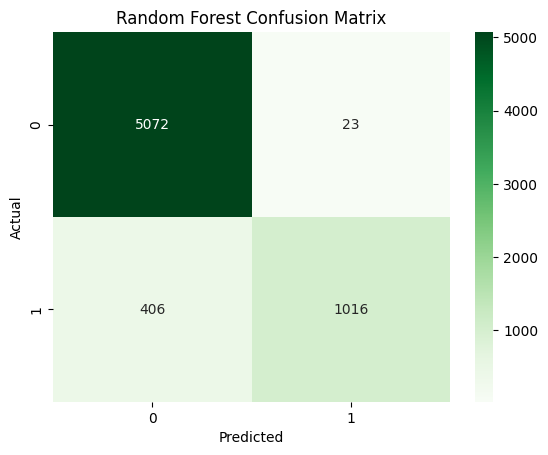

In [20]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

,feature,importance
5,loan_percent_income,0.198771
1,person_income,0.159210
4,loan_int_rate,0.128116
3,loan_amnt,0.081473
2,person_emp_length,0.054146
20,loan_grade_D,0.053906
0,person_age,0.048909
10,person_home_ownership_RENT,0.040834
6,cb_person_cred_hist_length,0.039070
17,loan_grade_A,0.021478


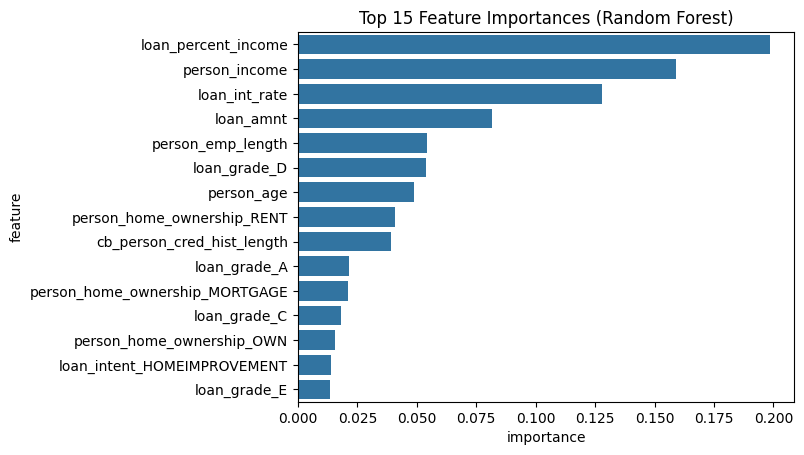

In [22]:
ohe = rf_clf.named_steps["preprocessor"].named_transformers_["cat"]\
            .named_steps["encoder"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

importances = rf_clf.named_steps["model"].feature_importances_
fi = (pd.DataFrame({"feature": feature_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .head(15))

display(fi)

sns.barplot(x="importance", y="feature", data=fi)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

In [24]:
joblib.dump(rf_clf, "/content/random_forest_credit_risk.pkl")

['/content/random_forest_credit_risk.pkl']

In [14]:
joblib.dump(
    {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "preprocessor": preprocessor,
        "categorical_cols": categorical_cols,
        "numerical_cols": numerical_cols
    },
    "/content/prep_artifacts.pkl"
)

['/content/prep_artifacts.pkl']